In [21]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
from scipy.stats import linregress
rcParams['figure.figsize'] = 14,10
plt.style.use('ggplot')

# NY Times Data
us_counties = "covid_data/us-counties.csv"
us_states = "covid_data/us-states.csv"
us_total = "covid_data/us.csv"
counties = pd.read_csv(us_counties)
states = pd.read_csv(us_states)
us = pd.read_csv(us_total)

us

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
173,2020-07-12,3318347,134977
174,2020-07-13,3379859,135402
175,2020-07-14,3445483,136356
176,2020-07-15,3513846,137327


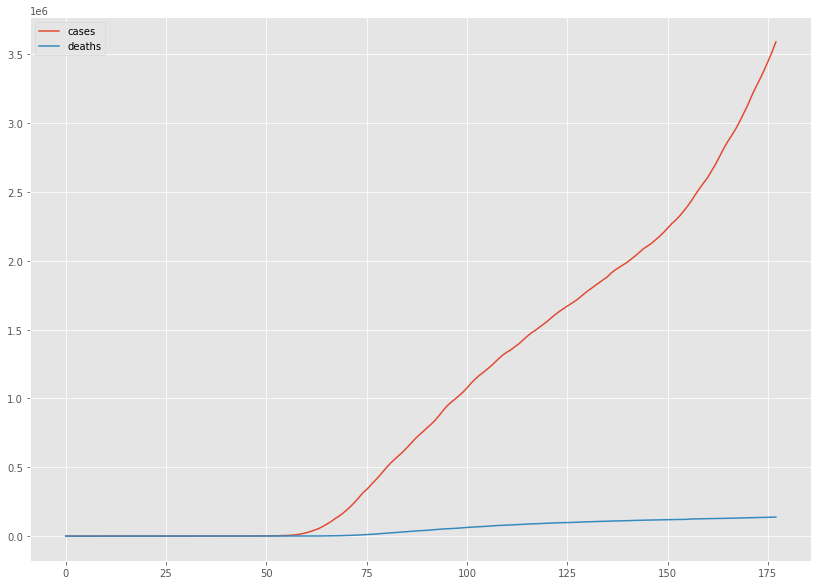

In [22]:
us.plot();
#states[['date','state','cases','deaths']].plot();
#counties.plot();

In [23]:
trump_data = "approval_ratings/trump_ratings.csv"
trump_ratings = pd.read_csv(trump_data)
trump_ratings.columns

Index(['president', 'subgroup', 'modeldate', 'startdate', 'enddate',
       'pollster', 'grade', 'samplesize', 'population', 'weight', 'influence',
       'approve', 'disapprove', 'adjusted_approve', 'adjusted_disapprove',
       'multiversions', 'tracking', 'url', 'poll_id', 'question_id',
       'createddate', 'timestamp'],
      dtype='object')

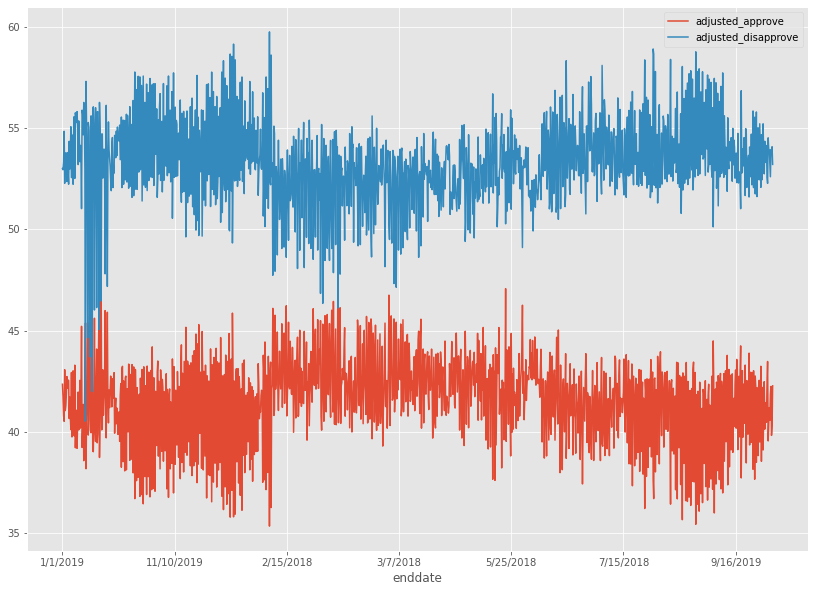

In [24]:
avg_trump_ratings =trump_ratings.groupby('enddate').agg({'adjusted_approve': 'mean', 'adjusted_disapprove': 'mean'})
avg_trump_ratings.plot();
#trump_ratings.plot(kind='line', x='enddate', y='disapprove')

In [25]:
# John's Hopkins Data
jh_data = "covid_data/time_series_covid19_deaths_US.csv"
jh_covid = pd.read_csv(jh_data)
jh_covid.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Lat', 'Long_', 'Combined_Key', 'Population', 'Country_Region'], inplace=True)
jh_covid.head(10)

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20
0,American Samoa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Guam,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
2,Northern Mariana Islands,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,Puerto Rico,0,0,0,0,0,0,0,0,0,...,159,159,159,167,167,167,169,171,172,177
4,Virgin Islands,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
5,Alabama,0,0,0,0,0,0,0,0,0,...,12,13,14,14,15,15,17,18,19,20
6,Alabama,0,0,0,0,0,0,0,0,0,...,9,10,11,11,11,11,11,12,13,13
7,Alabama,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,3,3,3,3
8,Alabama,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,2
9,Alabama,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [26]:
jh_pivot = pd.pivot_table(jh_covid, index=['Province_State'], aggfunc=np.sum, fill_value=0)
jh_pivot.head(10)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/16/20,7/17/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20
Province_State,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0,0,0,0,0,0,0,0,0,...,1230,1265,985,1006,1007,1007,1007,1033,1058,1068
Alaska,0,0,0,0,0,0,0,0,0,0,...,17,17,14,15,16,16,16,17,17,17
American Samoa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arizona,0,0,0,0,0,0,0,0,0,0,...,2492,2583,1764,1798,1817,1825,1829,1927,1963,2038
Arkansas,0,0,0,0,0,0,0,0,0,0,...,341,353,279,281,286,287,292,301,305,309
California,0,0,0,0,0,0,0,0,0,0,...,7489,7603,6265,6315,6334,6373,6441,6573,6718,6859
Colorado,0,0,0,0,0,0,0,0,0,0,...,1745,1751,1701,1701,1701,1701,1691,1696,1704,1706
Connecticut,0,0,0,0,0,0,0,0,0,0,...,4389,4396,4326,4335,4335,4335,4338,4338,4343,4348
Delaware,0,0,0,0,0,0,0,0,0,0,...,521,521,510,512,512,512,512,514,515,517


# Analysis of NYT Deaths vs Trump Approval Numbers

In [27]:
# To start we need one dataframe, with Four columns. Date, Total Deaths, Trump Approval Rating and Trump disapproval rating

# We can get the date the deaths by looking at the NYT data.
df_deathapproval = us[['date','deaths']]
df_deathapproval['date_clean'] = pd.to_datetime(df_deathapproval['date'])

In [28]:
# So now we need to get the approval rating and disapproval rating by date
import datetime
trump_ratings['enddate_clean'] = pd.to_datetime(trump_ratings['enddate'])
trump_ratings_2020 = trump_ratings.loc[trump_ratings['enddate_clean'] >= '01-21-2020'] 

trump_ratings_2020_grouped = trump_ratings_2020.groupby('enddate_clean')

approval = trump_ratings_2020_grouped['approve'].mean()
disapproval = trump_ratings_2020_grouped['disapprove'].mean()
adj_approval = trump_ratings_2020_grouped['adjusted_approve'].mean()
adj_disapproval = trump_ratings_2020_grouped['adjusted_disapprove'].mean()

#trump_ratings[['startdate','enddate','adjusted_approve']].loc[]

In [29]:
approval = pd.DataFrame(approval)
disapproval = pd.DataFrame(disapproval)
adj_approval = pd.DataFrame(adj_approval)
adj_disapproval = pd.DataFrame(adj_disapproval)


deathapproval_approve = pd.merge(df_deathapproval, adj_approval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')
deathapproval_adjapprove = pd.merge(deathapproval_approve, adj_disapproval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')
deathapproval_adjdisapprove = pd.merge(deathapproval_adjapprove, approval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')
df_approvalfinal = pd.merge(deathapproval_adjdisapprove, disapproval, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean')

df_approvalfinal

,date,deaths,date_clean,adjusted_approve,adjusted_disapprove,approve,disapprove
0,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222
1,2020-01-22,0,2020-01-22,41.966678,53.236632,42.769231,53.230769
2,2020-01-23,0,2020-01-23,45.602169,49.896615,46.580000,49.120000
3,2020-01-24,0,2020-01-24,42.208675,54.169452,42.375000,53.000000
4,2020-01-25,0,2020-01-25,41.138551,54.879570,42.000000,54.000000
...,...,...,...,...,...,...,...
173,2020-07-12,134977,2020-07-12,39.979799,56.477837,41.318182,56.045455
174,2020-07-13,135402,2020-07-13,40.762214,55.909417,41.111111,56.111111
175,2020-07-14,136356,2020-07-14,40.948665,54.881739,41.461538,54.153846
176,2020-07-15,137327,2020-07-15,40.921901,54.965856,42.800000,53.800000


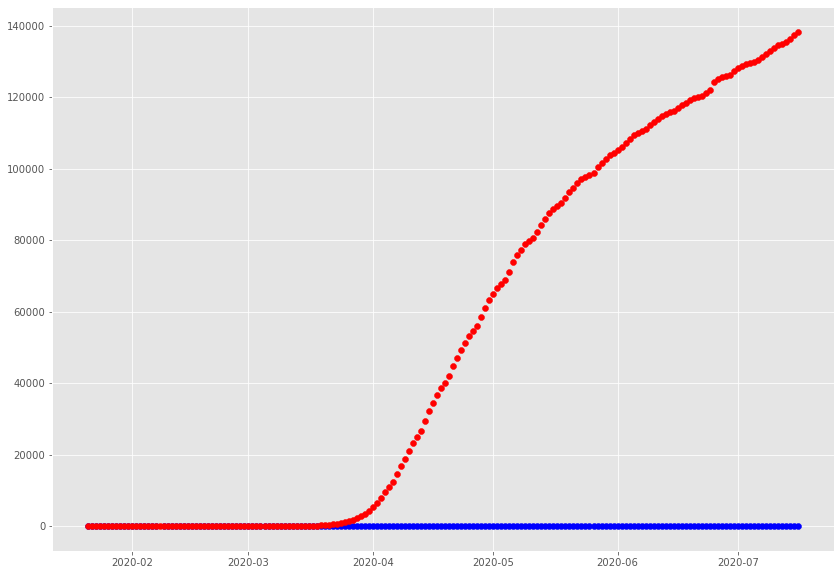

In [30]:
x_data = df_approvalfinal['date_clean']
y_data_adjapprove = df_approvalfinal['adjusted_approve']
y_data_approve = df_approvalfinal['approve']
y_data_deaths = df_approvalfinal['deaths']

plt.scatter(x = df_approvalfinal['date_clean'], y = df_approvalfinal['adjusted_approve'], c='blue')
plt.scatter(x = df_approvalfinal['date_clean'], y = df_approvalfinal['deaths'], c='red')

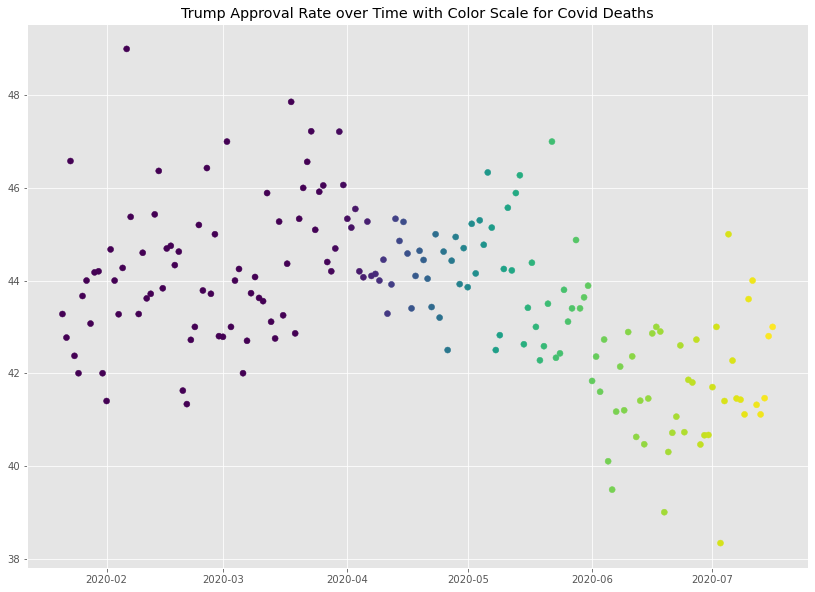

In [31]:
plt.scatter(x = x_data, y = y_data_approve, c = y_data_deaths)
plt.title('Trump Approval Rate over Time with Color Scale for Covid Deaths');

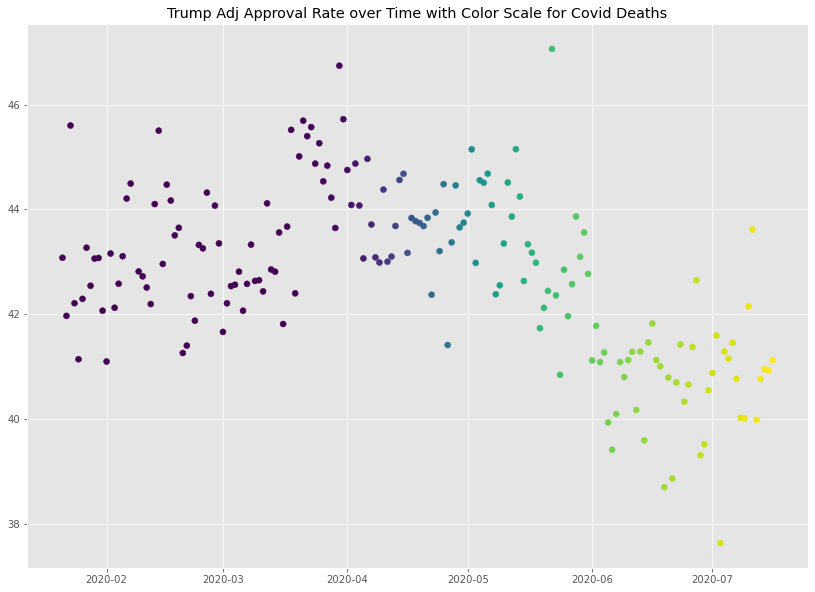

In [32]:
plt.scatter(x = x_data, y = y_data_adjapprove, c = y_data_deaths)
plt.title('Trump Adj Approval Rate over Time with Color Scale for Covid Deaths');

In [33]:
# Let's try to build a rolling average of the approval rating to smooth our graph.

trump_ratings['enddate_clean'] = pd.to_datetime(trump_ratings['enddate'])
trump_ratings['enddate_clean']

0       2017-01-22
1       2017-01-22
2       2017-01-24
3       2017-01-23
4       2017-01-25
           ...    
12716   2020-07-15
12717   2020-07-14
12718   2020-07-15
12719   2020-07-16
12720   2020-07-16
Name: enddate_clean, Length: 12721, dtype: datetime64[ns]

In [34]:
# Create empty lists to hold the day and the rolling average
from datetime import date, timedelta, datetime

days = []
rolling_approve = []
start_date = "01-22-2020"
end_date = pd.to_datetime(start_date) + pd.DateOffset(days = 3)


In [35]:
# Loop through the days
# for day in trump_ratings['enddate_clean'].unique():
#     # Attempt to build a new dataframe that filters for days within 3 days of our current date... THIS IS NOT WORKING, lets try to use datetime.timedelta()
#     date_1 = datetime.datetime.strptime(day, "%m/%d/%y")

    
#     dt_max = date_1 + timedelta(days = 3)
#     dt_min = date_1 - timedelta(days = 3)
#     df_day = trump_ratings.loc[(trump_ratings['enddate_clean'] >= dt_min) & (trump_ratings['enddate_clean'] <= dt_max)]
#     days.append(day)
#     rolling_approve.append(df_day['approve'].mean())
#     print(f"The rolling average for +/- three days from {day} is {df_day['approve'].mean()}")

# df_rollingapprove = pd.DataFrame({'Day': days, "Rolling Approval": rolling_approve})


# Loop through the days
#for day in trump_ratings['enddate_clean'].unique():
#    dt_max = day + timedelta(days = 3)
#    dt_min = day - timedelta(days = 3)

# Write code that compares datetime values and finds the difference, then we can use that to filter as boolean etc. etc.
# One option is to use datetime.timedelta

# Using current time 
#ini_time_for_now = datetime.now() 
  
# printing initial_date 
#print ("initial_date", str(ini_time_for_now)) 
  
# Calculating future dates 
# for two years 
#future_date_after_2yrs = ini_time_for_now + timedelta(days = 3) 
  
#future_date_after_2days = ini_time_for_now + timedelta(days = 2) 
  
# printing calculated future_dates 
#print('future_date_after_2yrs:', str(future_date_after_2yrs)) 
#print('future_date_after_2days:', str(future_date_after_2days))

In [36]:
#df_rollingapprove

In [37]:
#df_approvalfinal_withrolling = pd.merge(df_approvalfinal, df_rollingapprove, how = 'left', left_on = 'date_clean', right_on = 'Day')

#df_approvalfinal_withrolling.to_csv('compare.csv')

NameError: name 'df_rollingapprove' is not defined

In [ ]:
#x_data = df_approvalfinal_withrolling['date_clean']
#y_data_adjapprove_rolling = df_approvalfinal_withrolling['Rolling Approval']
#y_data_deaths = df_approvalfinal_withrolling['deaths']

#plt.scatter(x = x_data, y = y_data_adjapprove_rolling, c = y_data_deaths)
#plt.title('Trump Adj Approval Rate over Time with Color Scale for Covid Deaths');

In [ ]:
#plt.plot(y_data_adjapprove_rolling)

In [38]:
trump_ratings_2020

,president,subgroup,modeldate,startdate,enddate,pollster,grade,samplesize,population,weight,...,adjusted_approve,adjusted_disapprove,multiversions,tracking,url,poll_id,question_id,createddate,timestamp,enddate_clean
4523,Donald Trump,All polls,7/17/2020,1/16/2020,1/21/2020,AP-NORC,NaN,1353.0,a,1.647203,...,42.895074,53.465073,NaN,NaN,http://www.apnorc.org/projects/Documents/topli...,63331,116049,1/22/2020,7/17/2020 9:53,2020-01-21
4524,Donald Trump,All polls,7/17/2020,1/17/2020,1/21/2020,Global Strategy Group/GBAO (Navigator Research),NaN,1600.0,rv,0.955618,...,43.684459,52.802165,NaN,NaN,https://navigatorresearch.org/wp-content/uploa...,63370,116209,1/28/2020,7/17/2020 9:53,2020-01-21
4526,Donald Trump,All polls,7/17/2020,1/16/2020,1/22/2020,Morning Consult,B/C,3984.0,rv,0.203869,...,41.136218,54.901041,NaN,NaN,https://morningconsult.com/wp-content/uploads/...,63414,116435,1/31/2020,7/17/2020 9:53,2020-01-22
4527,Donald Trump,All polls,7/17/2020,1/16/2020,1/22/2020,Kaiser Family Foundation,NaN,1212.0,a,1.840207,...,42.777689,54.334207,NaN,NaN,http://files.kff.org/attachment/Topline-KFF-He...,63394,116353,1/30/2020,7/17/2020 9:53,2020-01-22
4528,Donald Trump,All polls,7/17/2020,1/18/2020,1/21/2020,YouGov,B,1000.0,a,0.115822,...,43.853797,54.089118,NaN,NaN,https://d25d2506sfb94s.cloudfront.net/cumulus_...,63327,116025,1/22/2020,7/17/2020 9:53,2020-01-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12716,Donald Trump,Voters,7/17/2020,7/13/2020,7/15/2020,Rasmussen Reports/Pulse Opinion Research,C+,1500.0,lv,0.152528,...,42.821395,51.675504,NaN,T,http://www.rasmussenreports.com/public_content...,67112,125416,7/16/2020,7/17/2020 9:55,2020-07-15
12717,Donald Trump,Voters,7/17/2020,7/13/2020,7/14/2020,Ipsos,B-,961.0,rv,0.786636,...,40.333788,53.959217,NaN,NaN,https://www.ipsos.com/sites/default/files/ct/n...,67109,125412,7/15/2020,7/17/2020 9:55,2020-07-14
12718,Donald Trump,Voters,7/17/2020,7/13/2020,7/15/2020,YouGov,B,783.0,rv,0.192359,...,39.249205,56.425250,NaN,NaN,https://docs.cdn.yougov.com/hi43cpnou0/tabs_Tr...,67105,125399,7/15/2020,7/17/2020 9:55,2020-07-15
12719,Donald Trump,Voters,7/17/2020,7/14/2020,7/16/2020,Rasmussen Reports/Pulse Opinion Research,C+,1500.0,lv,0.482497,...,40.821395,53.675504,NaN,T,http://www.rasmussenreports.com/public_content...,67118,125424,7/17/2020,7/17/2020 9:55,2020-07-16


In [39]:
# Maybe we should try rolling average another way

df_deathapproval
trump_ratings_2020.groupby('enddate_clean').adjusted_approve.rolling(7).mean()

enddate_clean       
2020-01-21     4523    NaN
               4524    NaN
               4528    NaN
               4529    NaN
               4530    NaN
                        ..
2020-07-16     5271    NaN
               5272    NaN
               8554    NaN
               12719   NaN
               12720   NaN
Name: adjusted_approve, Length: 1816, dtype: float64

In [71]:
# Now lets get the rolling approval and disapproval
rolling_approve = pd.DataFrame(trump_ratings_2020_grouped.adjusted_approve.mean().rolling('7d').mean())
rolling_approve

rolling_disapprove = pd.DataFrame(trump_ratings_2020_grouped.adjusted_disapprove.mean().rolling('7d').mean())

rollers = pd.merge(rolling_approve, rolling_disapprove, how = 'left', on = 'enddate_clean')
rollers

,adjusted_approve,adjusted_disapprove
enddate_clean,,
2020-01-21,43.076130,52.930799
2020-01-22,42.521404,53.083715
2020-01-23,43.548326,52.021349
2020-01-24,43.213413,52.558374
2020-01-25,42.798441,53.022614
...,...,...
2020-07-12,41.142716,55.005278
2020-07-13,41.043789,55.051744
2020-07-14,41.070407,55.020698


In [72]:
# Merge to the rolling data to our date table
df_roll = pd.merge(df_approvalfinal, rollers, how = 'left', left_on = 'date_clean', right_on = 'enddate_clean', suffixes = ('','_roll'))

# Finally lets try to fill in the undecided numbers

df_roll['adjusted_nochoice_roll'] = 100 - df_roll['adjusted_approve_roll'] - df_roll['adjusted_disapprove_roll']
df_roll.to_csv('compare.csv')
df_roll

,date,deaths,date_clean,adjusted_approve,adjusted_disapprove,approve,disapprove,adjusted_approve_roll,adjusted_disapprove_roll,adjusted_nochoice_roll
0,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,43.076130,52.930799,3.993071
1,2020-01-22,0,2020-01-22,41.966678,53.236632,42.769231,53.230769,42.521404,53.083715,4.394881
2,2020-01-23,0,2020-01-23,45.602169,49.896615,46.580000,49.120000,43.548326,52.021349,4.430326
3,2020-01-24,0,2020-01-24,42.208675,54.169452,42.375000,53.000000,43.213413,52.558374,4.228213
4,2020-01-25,0,2020-01-25,41.138551,54.879570,42.000000,54.000000,42.798441,53.022614,4.178946
...,...,...,...,...,...,...,...,...,...,...
173,2020-07-12,134977,2020-07-12,39.979799,56.477837,41.318182,56.045455,41.142716,55.005278,3.852005
174,2020-07-13,135402,2020-07-13,40.762214,55.909417,41.111111,56.111111,41.043789,55.051744,3.904468
175,2020-07-14,136356,2020-07-14,40.948665,54.881739,41.461538,54.153846,41.070407,55.020698,3.908895
176,2020-07-15,137327,2020-07-15,40.921901,54.965856,42.800000,53.800000,41.199154,54.921322,3.879524


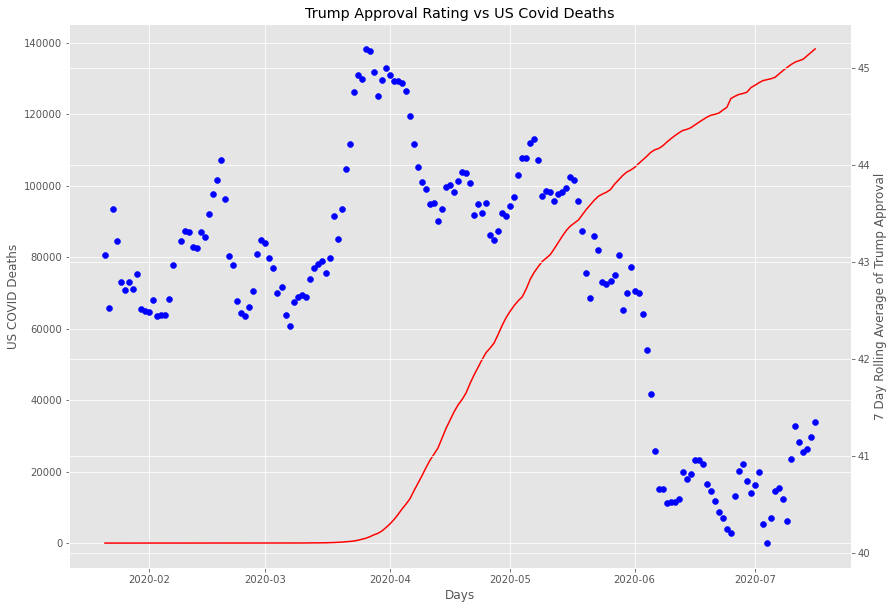

In [114]:
# Build a scatter plot of the approval rating along with a line graph of the aggregate COVID deaths
fig, ax1 = plt.subplots()
ax1.plot(x_data, deaths, color = 'red')
ax1.set_xlabel('Days')
ax1.set_ylabel('US COVID Deaths')

ax2 = ax1.twinx()

ax2.scatter(x = x_data, y = y_data_app, color = 'blue')
ax2.set_ylabel('7 Day Rolling Average of Trump Approval')

plt.title('Trump Approval Rating vs US Covid Deaths')

plt.savefig('Appoval_v_Deaths.png');

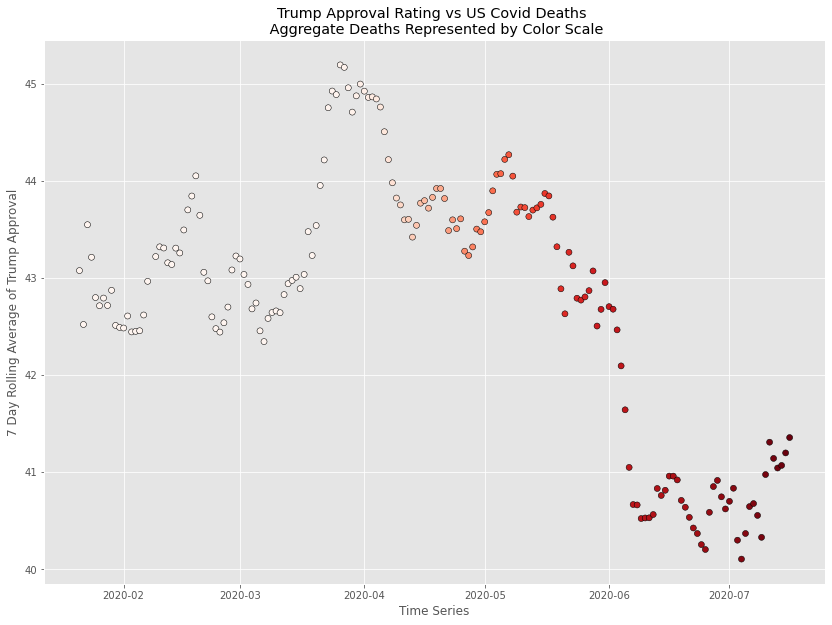

In [115]:
# build a scatter plot to look at the approval / disapproval as the color deaths increase
x_data = df_roll['date_clean']
y_data_app = df_roll['adjusted_approve_roll']
y_data_dis = df_roll['adjusted_disapprove_roll']
y_data_no = df_roll['adjusted_nochoice_roll']
deaths = df_roll['deaths']

# We can try to make this cleaner by using a sequential color map, like going in one pallatte from white to dark red, or something.
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

from matplotlib import cm

plt.scatter(x = x_data, y = y_data, c = deaths, cmap = 'Reds', edgecolors = 'black')

#plt.scatter(x = x_data, y = y_data_dis, c = deaths)

plt.title('Trump Approval Rating vs US Covid Deaths \n Aggregate Deaths Represented by Color Scale')

plt.xlabel('Time Series')
plt.ylabel('7 Day Rolling Average of Trump Approval')

plt.savefig('Approval_v_Deaths_ColorScaled.png');

In [84]:
# Another way to visualize the rolling, adjusted approval / disapproval is by a stacked bar chart? This didn't work so well
p1 = plt.bar(x_data, y_data_app)
p2 = plt.bar(x_data, y_data_dis)
p3 = plt.bar(x_data, y_data_no)

plt.ylabel('Approval and Disapproval Percentage')
plt.title('Trumps Approval Rating During COVID')

plt.legend((p1[0], p2[0], p3[0]), ('Approve', 'Disapprove', 'No Opinion'))

plt.show();

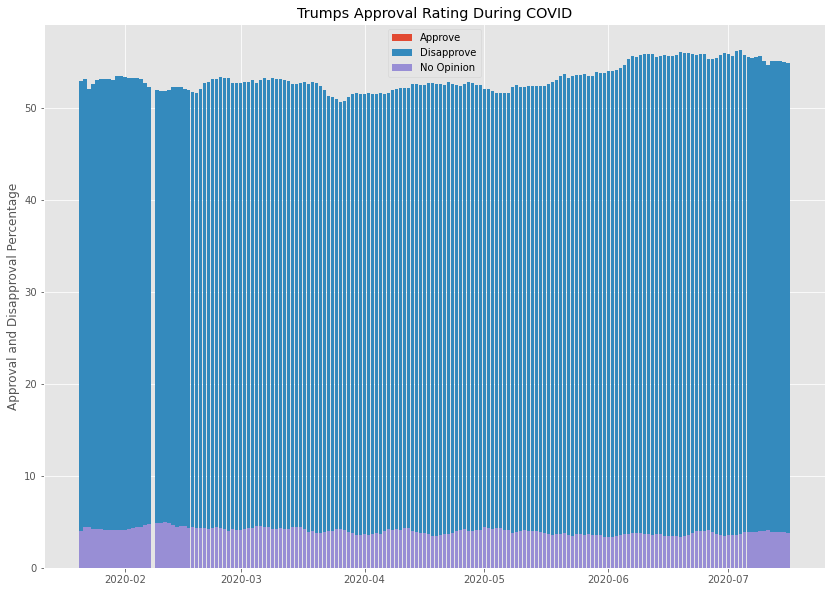

In [84]:
#Maybe this would work better with a pivot
df_roll.pivot()

In [113]:
# Jay recommended trying a Sankey chart, lets see what that looks like
import matplotlib.sankey as sankey

sankey.Sankey()


In [43]:
rolling_approve_all = pd.DataFrame(trump_ratings_2020.sort_values('enddate_clean').set_index('enddate_clean').adjusted_approve.rolling('3d').mean())
df_roll_all = pd.merge(df_approvalfinal, rolling_approve_all, how = 'right', left_on = 'date_clean', right_on = 'enddate_clean', suffixes = ('','_roll'))
df_roll_all

,date,deaths,date_clean,adjusted_approve,adjusted_disapprove,approve,disapprove,adjusted_approve_roll
0,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,42.895074
1,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,43.072139
2,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,43.464495
3,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,43.053720
4,2020-01-21,0,2020-01-21,43.076130,52.930799,43.277778,52.722222,43.692817
...,...,...,...,...,...,...,...,...
1811,2020-07-16,138284,2020-07-16,41.121901,54.565856,43.000000,53.400000,40.949226
1812,2020-07-16,138284,2020-07-16,41.121901,54.565856,43.000000,53.400000,40.994454
1813,2020-07-16,138284,2020-07-16,41.121901,54.565856,43.000000,53.400000,40.986213
1814,2020-07-16,138284,2020-07-16,41.121901,54.565856,43.000000,53.400000,40.922838


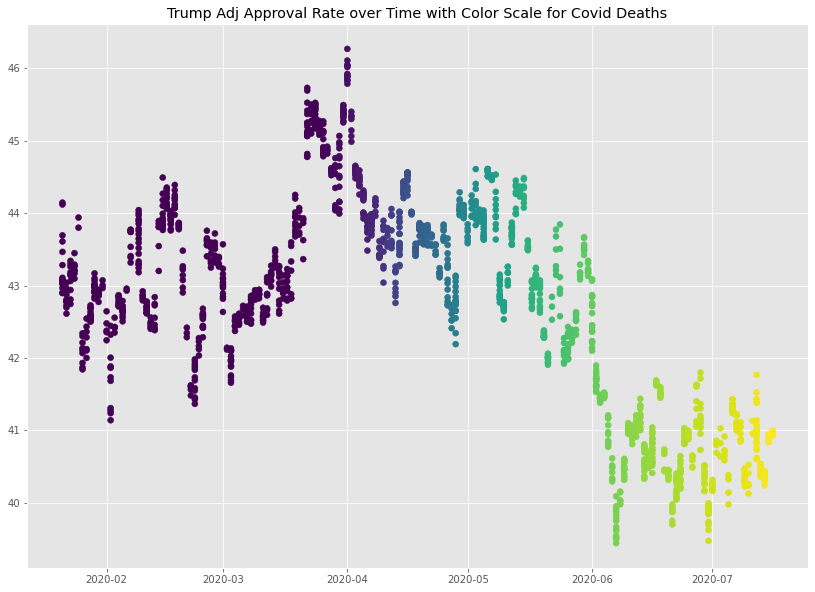

In [44]:
x_data = df_roll_all['date_clean']
y_data = df_roll_all['adjusted_approve_roll']
deaths = df_roll_all['deaths']

plt.scatter(x = x_data, y = y_data, c = deaths)
plt.title('Trump Adj Approval Rate over Time with Color Scale for Covid Deaths');